<a href="https://colab.research.google.com/github/thomasathul/Rice-Plant-Disease-Detection/blob/main/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import numpy as np
from sklearn.model_selection import train_test_split
import os
from glob import glob
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
IMAGE_SIZE = [224, 224]
train_path='/content/drive/MyDrive/kaggle/rice/ricedisease'

In [10]:
images = glob(os.path.join(train_path, '*/*.jpg'))
total_images = len(images)
print('Total images:', total_images)

Total images: 93


In [11]:
image_count = []
class_names = []

for folder in os.listdir(os.path.join(train_path)):
    folder_num = len(os.listdir(os.path.join(train_path, folder)))
    image_count.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)

Healthy              40
Bacterial leaf blight 40
Brown spot           40
Leaf smut            40


In [12]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet',  include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [13]:
for layer in inception.layers:
    layer.trainable = False

In [14]:
folders = glob('/content/drive/MyDrive/kaggle/rice/ricedisease/*')

In [15]:
folders

['/content/drive/MyDrive/kaggle/rice/ricedisease/Healthy',
 '/content/drive/MyDrive/kaggle/rice/ricedisease/Bacterial leaf blight',
 '/content/drive/MyDrive/kaggle/rice/ricedisease/Brown spot',
 '/content/drive/MyDrive/kaggle/rice/ricedisease/Leaf smut']

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                              shear_range = 0.2,
                                zoom_range = 0.2,
                                 horizontal_flip = True,
                                 validation_split=0.2
                                )
test_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)


In [17]:
validation_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/kaggle/rice/ricedisease', 
    shuffle=False, 
    class_mode="categorical",
    target_size=(224,224),
    batch_size=32,
    subset='validation'
    )

Found 32 images belonging to 4 classes.


In [18]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/kaggle/rice/ricedisease',
                              shuffle=True,
                                  target_size = (224, 224),
                                  batch_size = 32,
                                  class_mode = 'categorical',
                                  subset='training')

Found 128 images belonging to 4 classes.


In [19]:
model = tf.keras.Sequential([
    inception,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(training_set.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               26214912  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 48,019,748
Trainable params: 26,216,964
Non-trainable params: 21,802,784
_________________________________________________________________


In [21]:
LEARNING_RATE = 0.001
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
  metrics=['accuracy']
)

In [22]:
r = model.fit_generator(
  training_set,
  validation_data=validation_generator,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_generator)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
4/4 [==============================] - 78s 18s/step - loss: 49.9398 - accuracy: 0.2375 - val_loss: 52.1751 - val_accuracy: 0.3125
Epoch 2/10
4/4 [==============================] - 25s 6s/step - loss: 32.8654 - accuracy: 0.5188 - val_loss: 7.3660 - val_accuracy: 0.4688
Epoch 3/10
4/4 [==============================] - 25s 6s/step - loss: 7.4043 - accuracy: 0.5958 - val_loss: 3.5304 - val_accuracy: 0.7188
Epoch 4/10
4/4 [==============================] - 25s 6s/step - loss: 5.5942 - accuracy: 0.7542 - val_loss: 0.9704 - val_accuracy: 0.8750
Epoch 5/10
4/4 [==============================] - 25s 6s/step - loss: 2.0595 - accuracy: 0.8500 - val_loss: 2.0962 - val_accuracy: 0.8438
Epoch 6/10
4/4 [==============================] - 29s 7s/step - loss: 1.5952 - accuracy: 0.8885 - val_loss: 2.3368 - val_accuracy: 0.8125
Epoch 7/10
4/4 [==============================] - 26s 6s/step - loss: 0.9473 - accuracy: 0.9146 - val_loss: 0.9288 - val_accuracy: 0.8438
Epoch 8/10
4/4 [==============

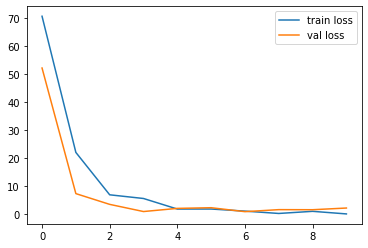

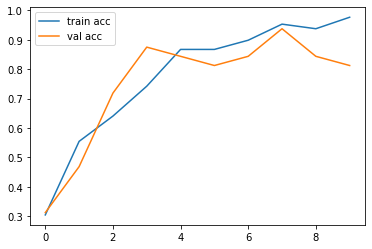

<Figure size 432x288 with 0 Axes>

In [23]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [24]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model.save('ricemodel_inception.h5')

In [42]:
import cv2
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(train_path, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    return {class_names[class_idx]: probabilities[class_idx]}

SOURCE: class: Leaf smut, file: Leaf smut/DSC_0310.JPG
PREDICTED: class: Leaf smut, confidence: 1.000000


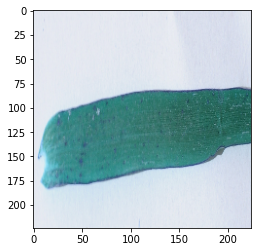

<Figure size 432x288 with 0 Axes>

SOURCE: class: Healthy, file: Healthy/IMG_20190419_172101.jpg
PREDICTED: class: Brown spot, confidence: 1.000000


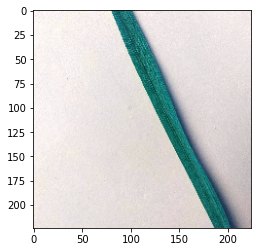

SOURCE: class: Leaf smut, file: Leaf smut/DSC_0312.JPG
PREDICTED: class: Leaf smut, confidence: 1.000000


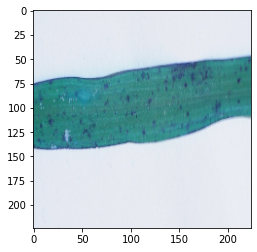

<Figure size 432x288 with 0 Axes>

SOURCE: class: Brown spot, file: Brown spot/DSC_0106.jpg
PREDICTED: class: Leaf smut, confidence: 1.000000


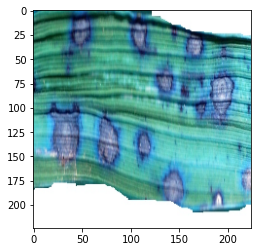

<Figure size 432x288 with 0 Axes>

SOURCE: class: Leaf smut, file: Leaf smut/DSC_0315.jpg
PREDICTED: class: Leaf smut, confidence: 1.000000


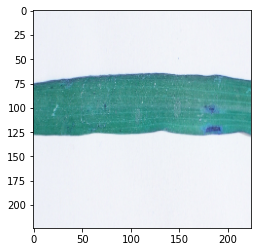

<Figure size 432x288 with 0 Axes>

In [43]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()